In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
#pack_cuda._ensure_initialized()


local


In [2]:
%load_ext pyinstrument

0.5 0.5
0.5 0.0
0.5 0.5
0.5 0.5
0.5 0.5
0.5 0.0
0.0 0.0
0.5 0.5
0.0 0.5
0.5 0.0


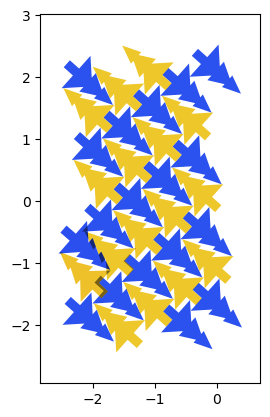

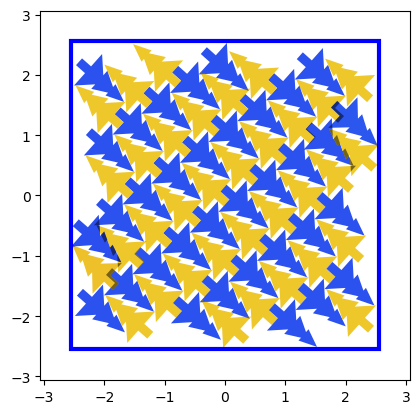

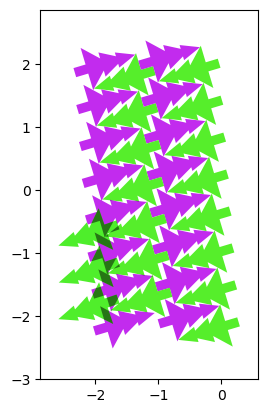

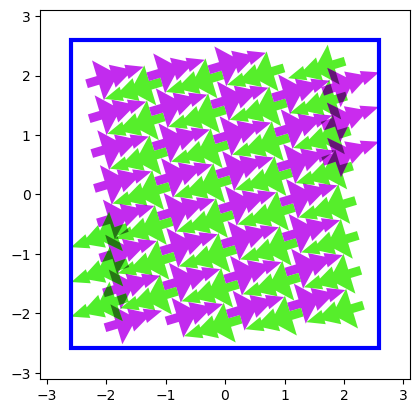

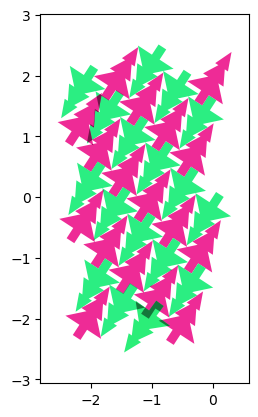

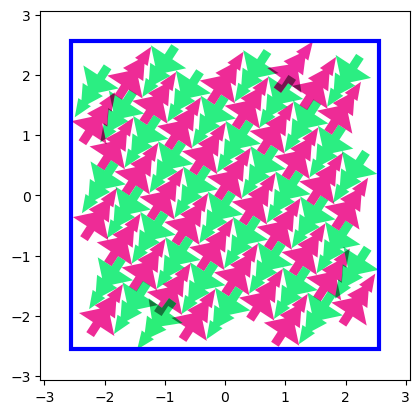

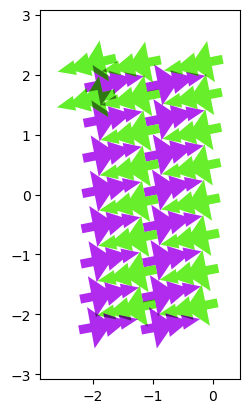

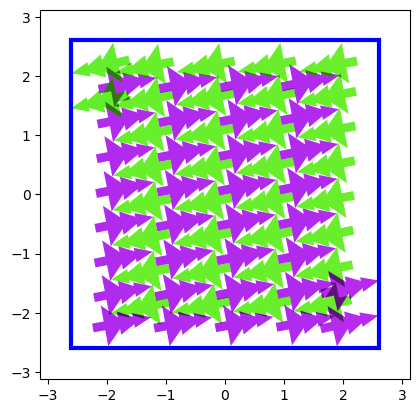

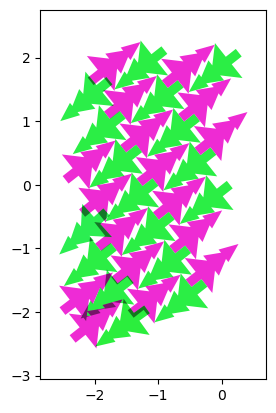

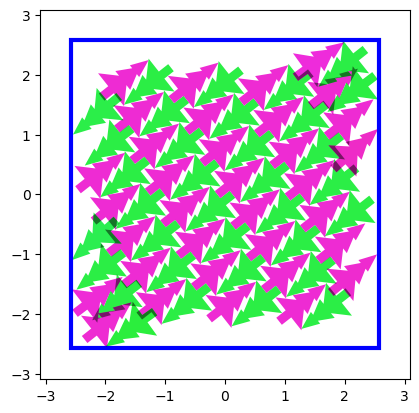

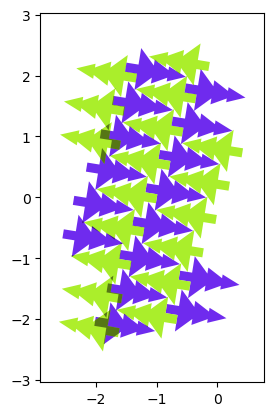

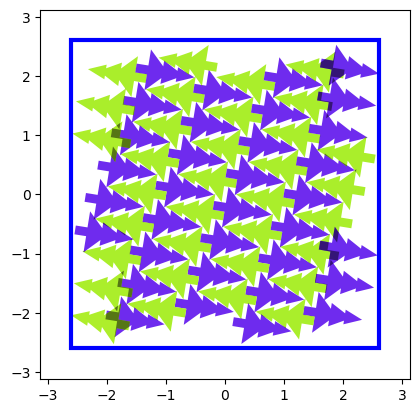

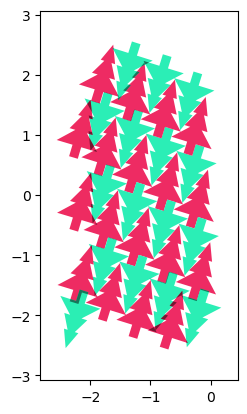

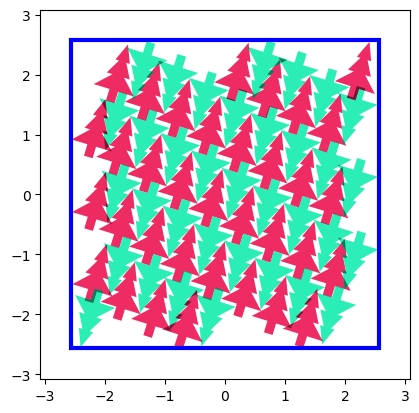

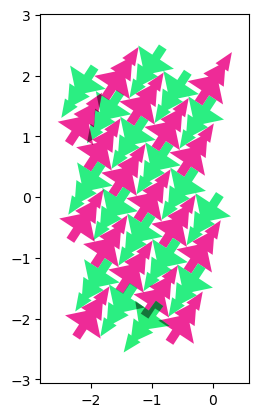

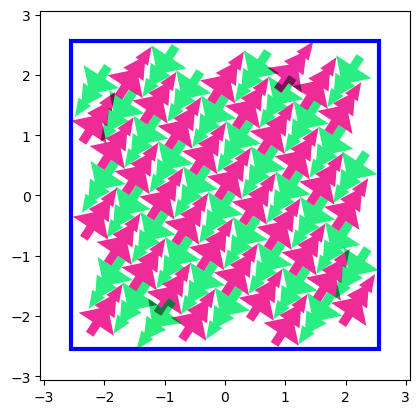

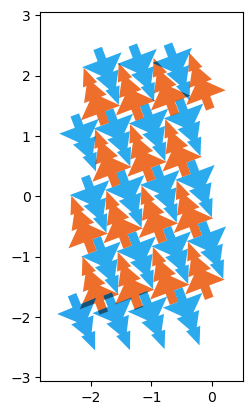

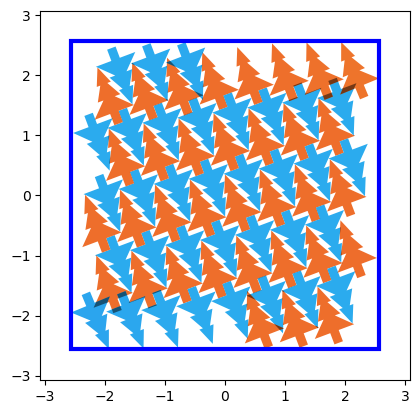

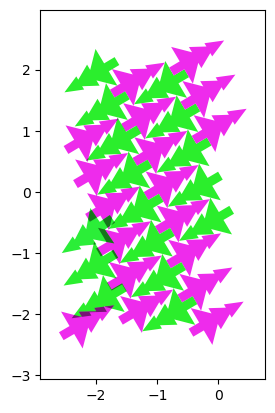

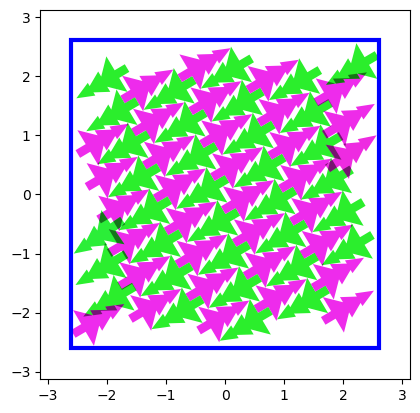

In [ ]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
#kgs.enable_module_profiling(kgs)
import pack_ga3
import pack_runner
importlib.reload(pack_ga3)
fastMode = False
kgs.debugging_mode = 2


runner = pack_ga3.baseline_symmetry_180()

#ref_sol = kgs.dill_load(kgs.temp_dir + '/controller_runs/done/ga_N68_seed507_done.pickle')
#runner.ga.ga_base.initializer.ref_sol = kgs.create_tiled_solution('Perfect dimer', 15,make_symmetric=True, axis1_offset=0., axis2_offset=0.5)
#runner.ga.ga_base.initializer.ref_sol.xyt[:,:,:2] += cp.array([0.2,0.2])
runner.ga.ga_base.initializer.ref_sol_crystal_type = 'Perfect dimer'
runner.ga.ga_base.initializer.ref_sol_axis1_offset = None
runner.ga.ga_base.initializer.ref_sol_axis2_offset = None
#runner.ga.ga_base.initializer.ref_rotate = None
#runner.ga.ga_base.initializer.ref_sol.canonicalize()
#runner.ga.ga_base.initializer.ref_N_scaling = 0.5
runner.ga.target_score = 0.

runner.ga.ga_base.N_trees_to_do = 68
runner.n_generations = 300
runner.diagnostic_plot = True
runner.seed = 1
runner.plot_every = 10
#runner.filter_before_rough = 1.

#runner.run()
# runner_temp = copy.deepcopy(runner)
# runner_temp.ga.ga_base.initializer.fixed_h = cp.array([np.sqrt(0.37*runner_temp.ga.ga_base.N_trees_to_do),0,0],dtype=kgs.dtype_cp)
# import pack_vis_sol
# for i in range(10):
#     runner_temp.ga.ga_base.initializer.seed = i
#     sol = runner_temp.ga.ga_base.initializer.initialize_population(10,runner_temp.ga.ga_base.N_trees_to_do)
#     pack_vis_sol.pack_vis_sol(sol.genotype, 0)
#     pack_vis_sol.pack_vis_sol(sol.phenotype, 0)

In [ ]:
#kgs.packings

{'Perfect dimer': SolutionCollectionLatticeFixed(comment='', xyt=array([[[ 0.12505924, -0.21787399,  1.23938439],
         [-0.12505924,  0.21787399,  4.3811095 ]]]), h=array([[1.21021177]]), use_fixed_h=False, periodic=True, N_periodic=2, override_phenotype=False, do_snap=True, aspect_ratios=array([0.48601985]), angles=array([1.02460664])),
 'Base sees trunk': SolutionCollectionLatticeFixed(comment='', xyt=array([[[ 0.20678725, -0.1513583 ,  1.51524437],
         [-0.20678725,  0.1513583 ,  4.65683726]]]), h=array([[1.27232422]]), use_fixed_h=False, periodic=True, N_periodic=2, override_phenotype=False, do_snap=True, aspect_ratios=array([0.42312885]), angles=array([1.13482957])),
 'Close under': SolutionCollectionLatticeFixed(comment='', xyt=array([[[-0.15858647,  0.17208573, -1.39412155],
         [ 0.15858647, -0.17208573,  1.74747087]]]), h=array([[0.90656456]]), use_fixed_h=False, periodic=True, N_periodic=2, override_phenotype=False, do_snap=True, aspect_ratios=array([0.76074774]

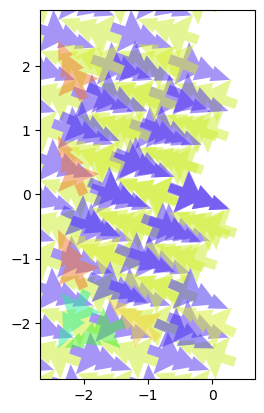

In [ ]:
# import pack_vis_sol
# for i in range(sol.phenotype.N_solutions):
#     #_,ax=plt.subplots()
#     runner_temp.ga.ga_base.initializer.ref_sol = kgs.create_tiled_solution('Perfect dimer', 15,make_symmetric=True, axis1_offset=0.0, axis2_offset=0.5)
#     xx=copy.deepcopy(runner_temp.ga.ga_base.initializer.ref_sol)
#     #xx.xyt[:,:,1] *= -1
#     #xx.xyt[:,:,2] += np.pi
#     #xx.rotate(cp.array([np.pi/20]))
#     xx.canonicalize()
#     #xx.xyt[:,:,:2] += cp.array([0.2,0.2])
#     #pack_vis_sol.pack_vis_sol(xx, solution_idx=i,ax=ax,alpha=0.5)
#     _,ax=plt.subplots()
#     pack_vis_sol.pack_vis_sol(xx, solution_idx=i,ax=ax,alpha=0.5)
#     #_,ax=plt.subplots()
#     x = copy.deepcopy(ref_sol.ga.champions[0].genotype)
#     x.rotate(cp.array([np.pi/2]))
#     pack_vis_sol.pack_vis_sol(x, solution_idx=0,ax=ax,alpha=0.5)
    
    

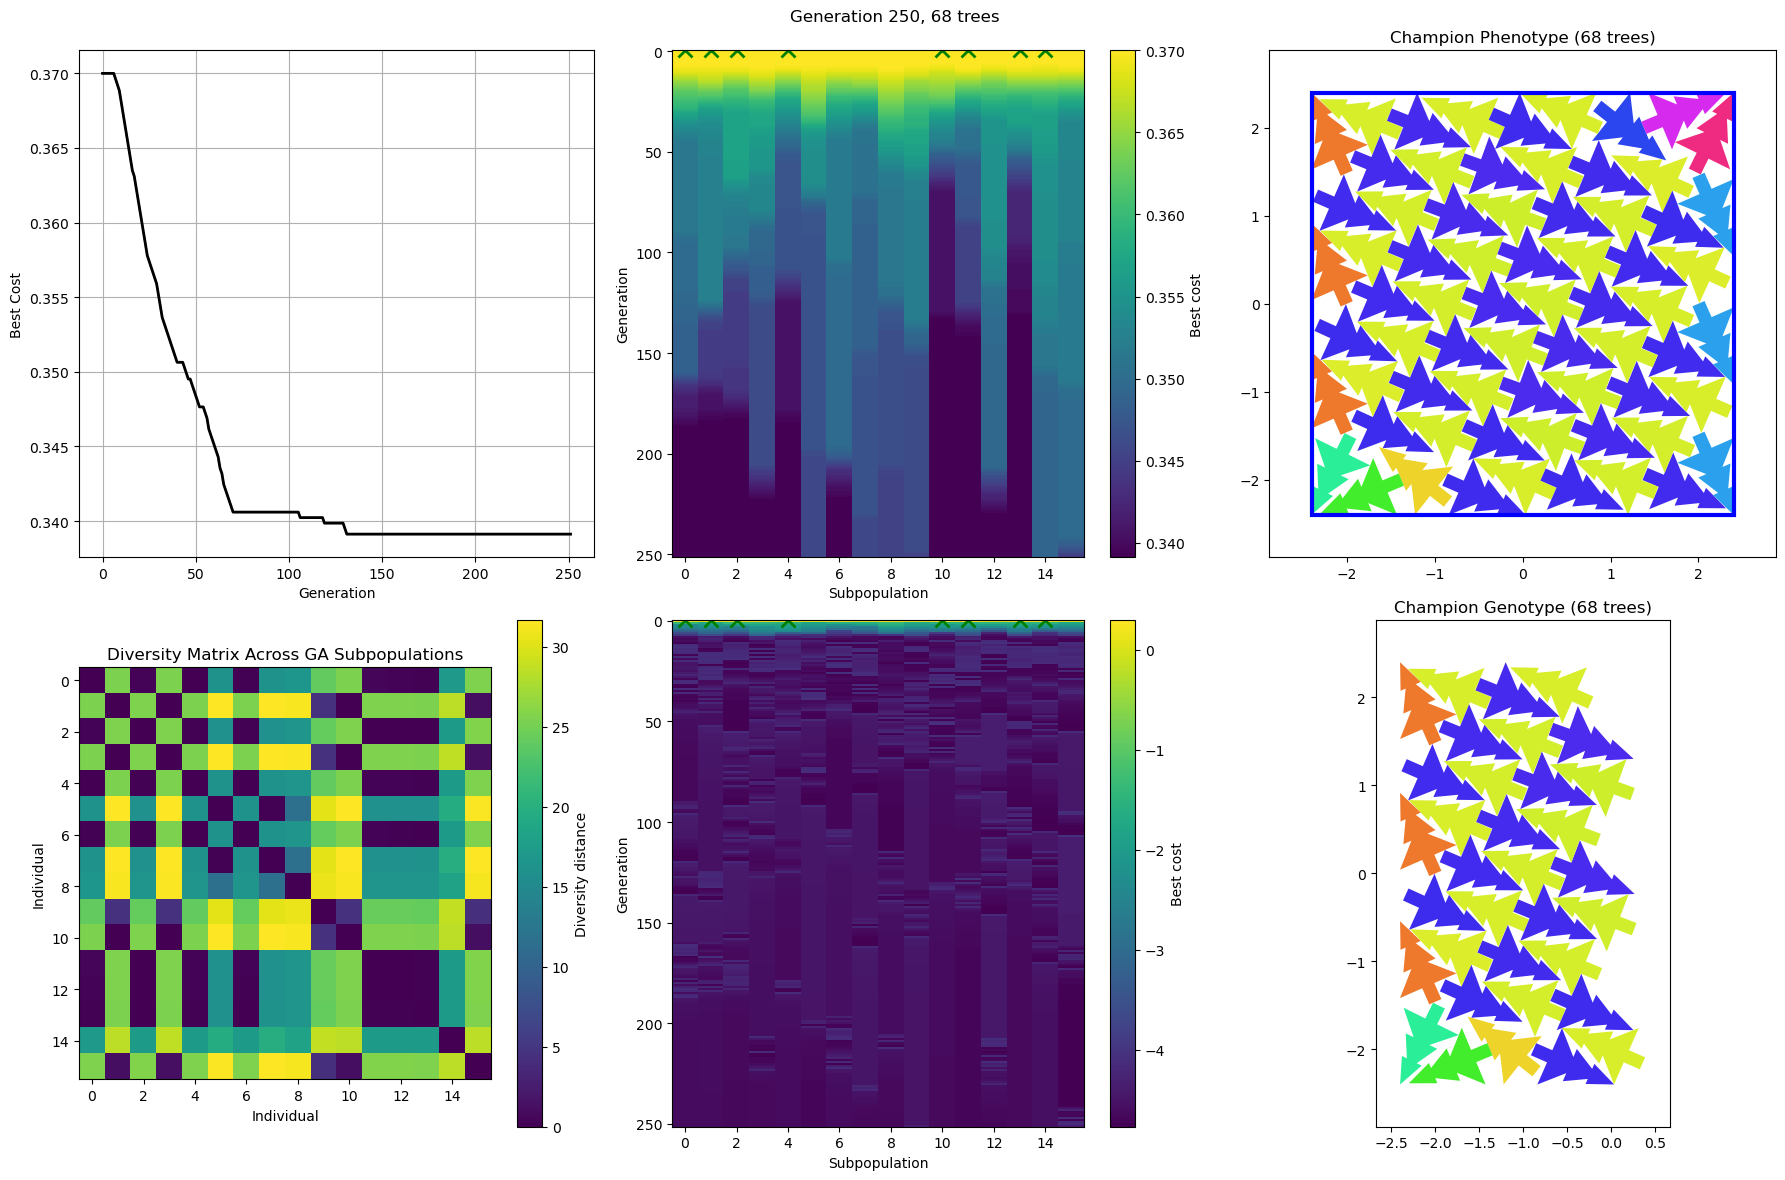

In [ ]:
# runner.run()